# ECommerce Examples with Featureform on Azure using Azure Blob Storage, MongoDB, & Spark

In this notebook we'll show you an end-to-end example of how to use a Virtual Feature Store (like Featureform) as part of the data science workflow on a [real commercial dataset of 100k orders](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_orders_dataset.csv). 


---


## 🎯 `Most Important Takeaways`

Specifically you'll see examples of:

*   ✅ How to connect to providers like Azure, MongoDB, & Databricks

*   ✅ How to connect to different Parquet files as sources 

*   ✅ Writing transformations using Spark SQL & Spark Datafram operations

*   ✅ Chaining transformations as DAGs & using curly bracket notation to reference different versions of sources & transformations

*   ✅ Creating different variants of features & training sets & zipping them up 

*   ✅ "Write once, serve twice" - Serving features for training & for production inference is as simple as providing a key & specifying whichh model & set of features you'd like to use for specific entities 









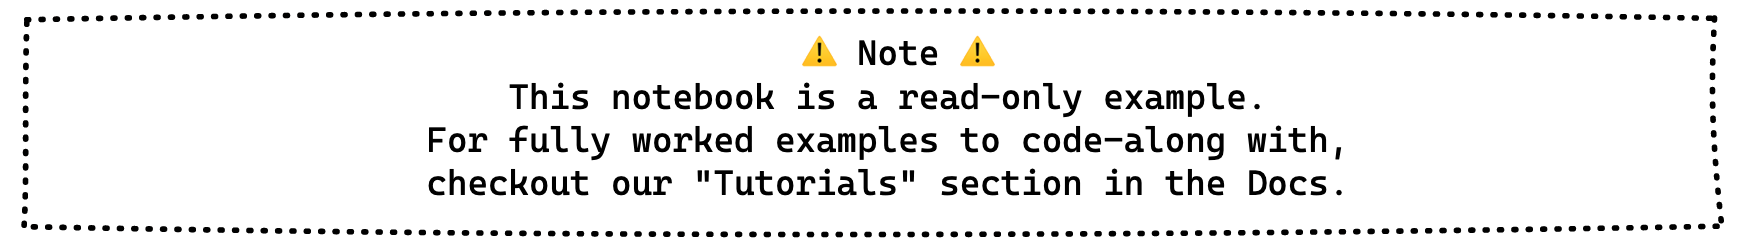

# ➡️ Pre-Reqs

**Mount GDrive**

The Google Drive will be used to access the credential files for Azure Blob Store, MongoDB, and Databricks. Make sure you have your credentials file in your drive under *credentials* folder. You will be asked to give access to mount your drive. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Verify that the credential files are accessible. Make sure you've created a shortcut to the '_credentials' folder in your GDrive.

In [ ]:
!ls ./drive/Drive/credentials/credentials/

aws_info.env  azure_redisent.env      bigquery.json
azure.env     azure_redis_paired.env  firestore.json


In [ ]:
!pip3 -q install python-dotenv

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path='/content/drive/Drive/credentials/azure.env')

True

In [ ]:
AZURE_ACCOUNT_KEY=os.getenv("AZURE_ACCOUNT_NAME")
AZURE_ACCOUNT_NAME=os.getenv("AZURE_ACCOUNT_KEY")
AZURE_CONTAINER_NAME=os.getenv("AZURE_CONTAINER_NAME")
DATABRICKS_HOST=os.getenv("DATABRICKS_HOST")
DATABRICKS_TOKEN=os.getenv("DATABRICKS_TOKEN")
DATABRICKS_CLUSTER=os.getenv("DATABRICKS_CLUSTER")
MONGODB_HOST=os.getenv("MONGODB_HOST")
MONGODB_PORT=os.getenv("MONGODB_PORT")
MONGODB_USERNAME=os.getenv("MONGODB_USERNAME")
MONGODB_PASSWORD=os.getenv("MONGODB_PASSWORD")
MONGODB_DATABASE=os.getenv("MONGODB_DATABASE")

# 📋 Getting Setup



### Install & Import Featureform

In [ ]:
!pip  install featureform --disable-pip-version-check

import featureform as ff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 KB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 7.7 MB/s eta 0:00:00
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=38f1c0b60e0fcaff9222ff0110e98b2f578d4739fafbae000e19c95926209d92
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=b109b717a0ef425206e1319f435d112059b356cf9432ca6effe2f4d7c73de7

### Register host

In [ ]:
client = ff.ResourceClient("<INSERT-HOST>")

#🏪  Using Featureform

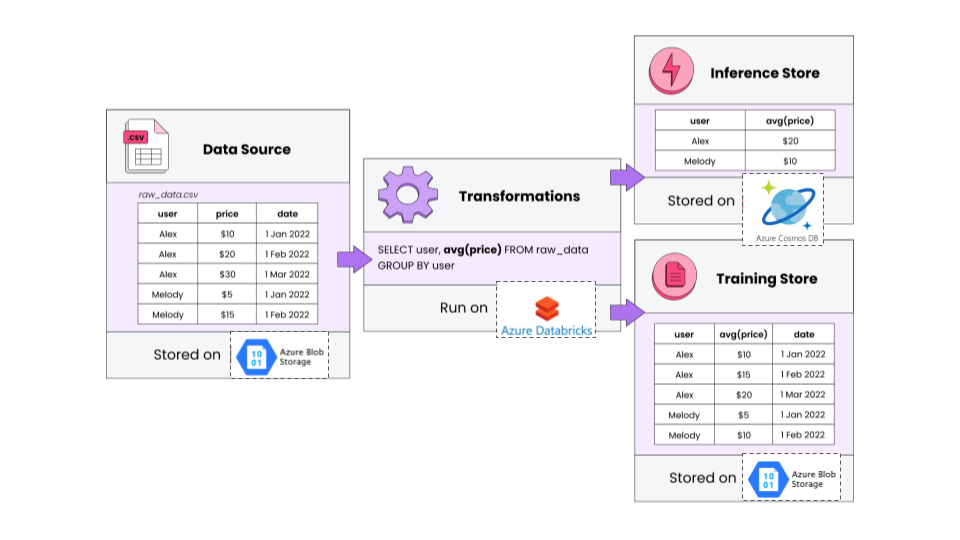

## [Register Infrastructure Providers](https://docs.featureform.com/getting-started/registering-infrastructure-providers)



> *Featureform coordinates a set of infrastructure providers to act together as a feature store. Before transformations, features, and other resources can be defined, an initial set of providers must be configured. This is done via a Python API and applied via the Featureform CLI.*



💬 In this case,

*   `Azure Spark (Databricks + Blob Store)` ➡️ Offline Store = provides dataset storage, transformation capabilities, and training set serving.
*   `MongoDB `➡️ Inference Store = allows feature values to be looked up at inference time.

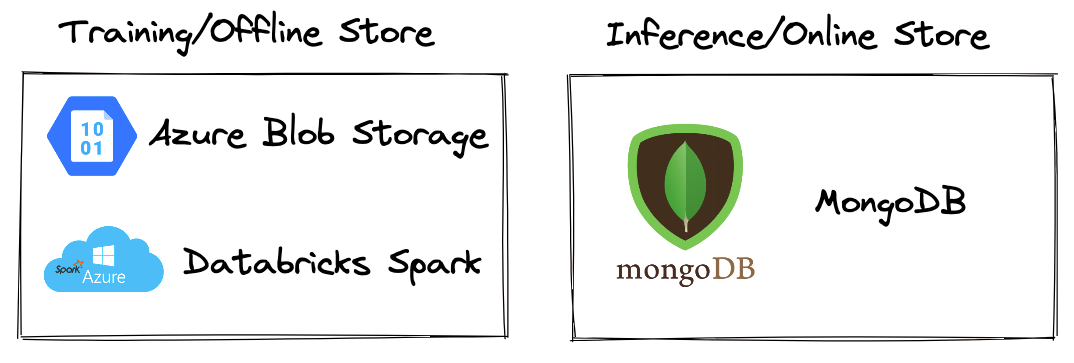

### 📌 Please be sure to check out our ["Providers"](https://docs.featureform.com/getting-started/registering-infrastructure-providers) pages for more information on the credentials needed to connect or "register" different providers.

In [ ]:
azure_blob = ff.register_blob_store(
    name="testing_blob_store",
    account_name=AZURE_ACCOUNT_KEY,
    account_key=AZURE_ACCOUNT_NAME,
    container_name="<INSERT-CONTAINER-NAME>",
    root_path="",
)

databricks = ff.DatabricksCredentials(
    host=DATABRICKS_HOST,
    token=DATABRICKS_TOKEN,
    cluster_id=DATABRICKS_CLUSTER,
)

spark = ff.register_spark(
    name="spark_provider",
    executor=databricks,
    filestore=azure_blob
)

mongo = ff.register_mongodb(
    name="mongodb",
    host=MONGODB_HOST,
    port=MONGODB_PORT,
    username=MONGODB_USERNAME,
    password=MONGODB_PASSWORD,
    database=MONGODB_DATABASE,
    throughput=10000
)


## [Register Primary Data Sources](https://docs.featureform.com/getting-started/transforming-data) 
Ex: Parquet Files



> *Once the infrastructure is configured, features and training sets can be created. This begins by registering a set of primary data sources, often followed by defining a DAG of transformations. Once the transformed sources are created, features and training sets can be defined. Other metadata such as descriptions, variants, and names are also defined in this step. In the enterprise editions, governance rules that the organization created will be enforced here. All these steps are done via a Python API and applied via the Featureform CLI.*



We'll be reading in parquet files that include data about payments, orders, customers, and reviews. 

Users can connect [both files and tables](https://docs.featureform.com/getting-started/transforming-data) from databases and buckets (including CSV, etc). 

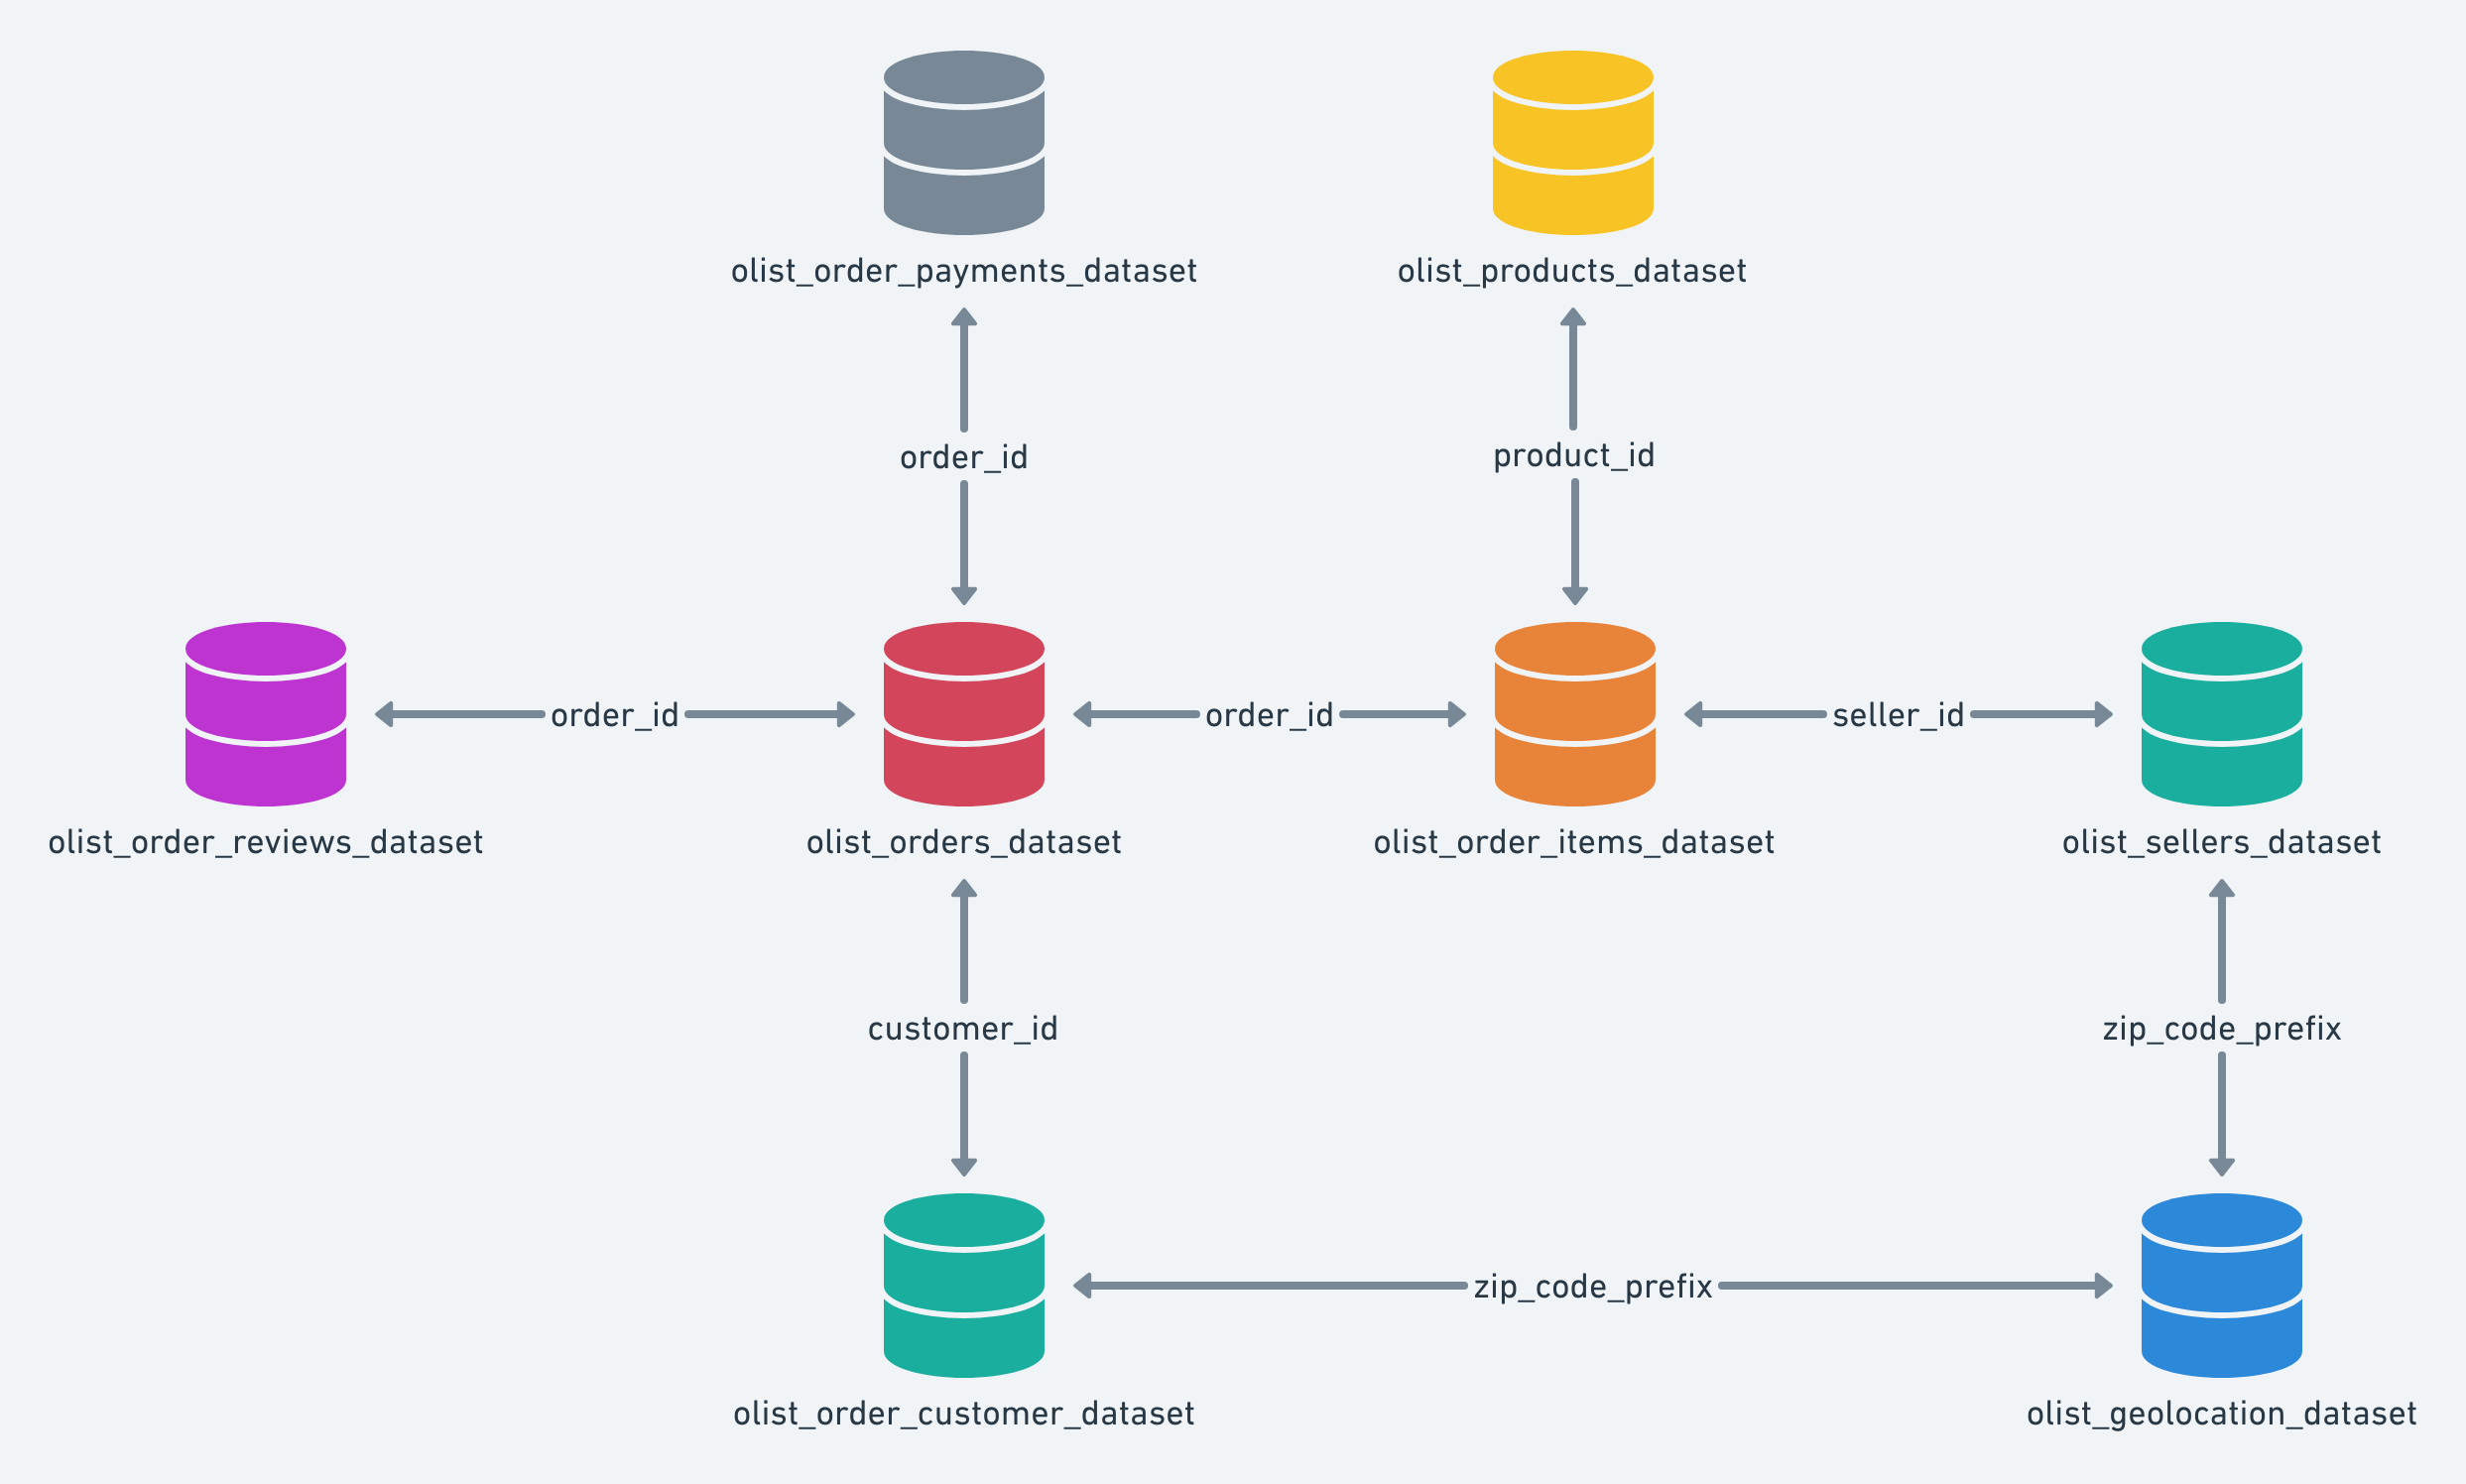

In [ ]:
payments = spark.register_parquet_file(
    name="payments",
    variant="default",
    description="This dataset includes data about the orders payment options.",
    file_path="<INSERT-FILE-PATH-TO>/ecommerce_order_payments_dataset.parquet",
)

In [ ]:
orders = spark.register_parquet_file(
    name="orders",
    variant="default",
    description="This is the core dataset. From each order you might find all other information.",
    file_path="<INSERT-FILE-PATH-TO>/ecommerce_orders_dataset.parquet",
)

In [ ]:
customers = spark.register_parquet_file(
    name="customers",
    variant="default",
    description="This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location.",
    file_path="<INSERT-FILE-PATH-TO>/ecommerce_customers_dataset.parquet",
)

In [ ]:
reviews = spark.register_parquet_file(
    name="reviews",
    variant="default",
    description="This dataset includes data about the reviews made by the customers.",
    file_path="<INSERT-FILE-PATH-TO>/ecommerce_order_reviews_dataset.parquet",
)

## [Register our transformations](https://docs.featureform.com/getting-started/transforming-data)

💬 There are two supported transformation types: SQL and Dataframes. Not all providers support all transformation types. 



> *Each transformation definition also includes a set of metadata like its name, variant, and description.*

### [SQL Example](https://docs.featureform.com/getting-started/transforming-data#sql): Get total payments per day

In [ ]:
# Get total payments per customer day
@spark.sql_transformation(name="total_paid_per_customer_per_day",
                          variant="default",
                          description="Get the daily total value of payments per customer.")
def total_paid_per_customer_per_day():
    return "select trunc(order_approved_at,'day') as day_date, c.customer_unique_id, sum(p.payment_value) as total_customer_order_paid "\
            "from {{payments.default}} p "\
            "join {{orders.default}} o on (o.order_id = p.order_id) "\
            "join {{customers.default}} c on (c.customer_id = o.customer_id) "\
            "group by 1,2 order by 1 asc "

In [ ]:
# Get total payments per day
@spark.sql_transformation(name="total_paid_per_day",
                          variant="default",
                          description="Get the daily total value of payments.")
def total_paid_per_day():
    return "select trunc(order_approved_at,'day') as day_date, sum(p.payment_value) as total_order_paid "\
            "from {{payments.default}} p "\
            "join {{orders.default}} o on (o.order_id = p.order_id) "\
            "group by 1 order by 1 asc "

### [Dataframes Example](https://docs.featureform.com/getting-started/transforming-data#chaining-transformations): Get average total payments per day

In [ ]:
# Get average order value per day
@spark.df_transformation(inputs=[("total_paid_per_customer_per_day", "default")], variant="default")
def average_daily_transaction(df):
    from pyspark.sql.functions import mean
    return df.groupBy("day_date").agg(mean("total_customer_order_paid").alias("average_order_value"))

###  Using unstructured data like text: Getting order reviews

In [ ]:
#Get reviews and review scores 
@spark.sql_transformation(name="reviews_by_order",
                          variant="default",
                          description="get reviews by order")
def reviews_by_order():
  return "select order_id, review_score, "\
          "concat(review_comment_title, '-',review_comment_message) as review_text " \
          "from {{reviews.default}} r " \
          "where (review_comment_title is not null) and (review_comment_message is not null) " \
          "and (review_comment_title <> '') and (review_comment_message <> '') " \
          "limit 50"

### [Transformation DAGs](https://docs.featureform.com/getting-started/transforming-data#chaining-transformations): Getting sum of orders after first month of purchase

Transformations can be daisy chained and can be used as inputs to downstream transformations. 

In [ ]:
# Get month 1 and month 6 dates from earliest purchase
@spark.sql_transformation(name="calculate_month_1_month_6_dates",
                          variant="default",
                          description="Calculate month 1 - 6")
def calculate_month_1_month_6_dates():
    return "select customer_unique_id, to_date(earliest_purchase) as earliest_datetime_purchase, "\
    "date_add(to_date(earliest_purchase),30) as  month_1_datetime, "\
    "date_add(to_date(earliest_purchase),150) as  month_6_datetime "\
    "from (select c.customer_unique_id, min(o.order_approved_at) as earliest_purchase "\
    "from {{orders.default}} o join {{customers.default}} c on (c.customer_id = o.customer_id) group by 1 "\
    "limit 100)"

For example, rather than a collection of nested CTE's, we chose to split out calculating dates from calculatign the revenue on those dates. 

Some of the benefits of the modular approach means if the business logic were to change for only one layer of the SQL chain, the rest of the transformations would only need to be updated the with version or `variant` of the same feature.

Whether you choose to write long queries or a series of short modular ones, both styles are possible using Featureform.

In [ ]:
# Get sum of purchases made in first month
@spark.sql_transformation(name="get_month_1_customer_spend",
                          variant="default",
                          description="Get month 1 customer spend")
def get_month_1_customer_spend():
    return "select cm.customer_unique_id, sum(p.payment_value) as month_1_value "\
    "from {{orders.default}} o "\
    "join {{customers.default}} c on (c.customer_id = o.customer_id) "\
    "join {{calculate_month_1_month_6_dates.default}} cm on (cm.customer_unique_id = c.customer_unique_id) "\
    "join {{payments.default}} p on (p.order_id = o.order_id) "\
    "where (to_date(o.order_approved_at) < month_1_datetime) or (to_date(o.order_approved_at) = month_1_datetime) "\
    "group by 1"

In [ ]:
# Get sum of purchases made between months 1 - 6
@spark.sql_transformation(name="get_month_6_customer_spend",
                          variant="default",
                          description="Get month 6 customer spend")
def get_month_6_customer_spend():
    return "select cm.customer_unique_id, sum(p.payment_value) as month_6_value "\
    "from {{orders.default}} o "\
    "join {{customers.default}} c on (c.customer_id = o.customer_id) "\
    "join {{calculate_month_1_month_6_dates.default}} cm on (cm.customer_unique_id = c.customer_unique_id) "\
    "join {{payments.default}} p on (p.order_id = o.order_id) "\
    "where (to_date(o.order_approved_at) < month_6_datetime) "\
    "group by 1"

## [Register Features and Labels](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets)

### [Registering entities](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#registering-entities): Orders, Customers, Daydate 

💬 Every feature must describe an entity. An entity can be thought of as a primary key table, and every feature must have at least a single foreign key entity field.

> *Common entities include users, items, and purchases. Entities can be anything that a feature can describe.*

In [ ]:
order = ff.register_entity("order")

In [ ]:
customer = ff.register_entity("customer")

In [ ]:
daydate = ff.register_entity("daydate")

### [Registering features & labels](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#registering-features-and-labels): Avg orders, Reviews data, etc

> *Once our entities are specified, we can begin to associate features and labels with them. Features and labels are each made up of at least two columns, an entity column and a value column. Features and labels that change value over time should be linked to a timestamp column as well. The timestamp column also allows us to create [point-in-time correct training data](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#point-in-time-correctness).*

**We'll add the daily revenue transformations as features**

In [ ]:
total_paid_per_day.register_resources(
    entity=daydate,
    entity_column="day_date",
    inference_store=mongo,
    labels=[
        {"name": "total_order_paid", "variant": "default", "column": "total_order_paid", "type": "float32"},
    ]
)

In [ ]:
average_daily_transaction.register_resources(
    entity=daydate,
    entity_column="day_date",
    inference_store=mongo,
    features=[
        {"name": "average_order_value", "variant": "default", "column": "average_order_value", "type": "float32"},
    ],
)

**We'll add the `review_text` as a feature and `review_score` as a label.**

In [ ]:
reviews_by_order.register_resources(
    entity=order,
    entity_column="order_id",
    inference_store=mongo,
    features=[
        {"name": "review_text", "variant": "default", "column": "review_text", "type": "str"},
    ],
    labels=[
        {"name": "review_score", "variant": "default", "column": "review_score", "type": "int"},
    ]
)

**We'll add the spend columns**

In [ ]:
calculate_month_1_month_6_dates.register_resources(
    entity=customer,
    entity_column="customer_unique_id",
    inference_store=mongo,
    features=[
        {"name": "earliest_datetime_purchase", "variant": "default", "column": "earliest_datetime_purchase", "type": "date"},
        {"name": "month_1_datetime", "variant": "default", "column": "month_1_datetime", "type": "date"},
        {"name": "month_6_datetime", "variant": "default", "column": "month_6_datetime", "type": "date"},
    ],
)

In [ ]:
get_month_1_customer_spend.register_resources(
    entity=customer,
    entity_column="customer_unique_id",
    inference_store=mongo,
    features=[
        {"name": "month_1_value", "variant": "default", "column": "month_1_value", "type": "float32"},
    ],
)

In [ ]:
get_month_6_customer_spend.register_resources(
    entity=customer,
    entity_column="customer_unique_id",
    inference_store=mongo,
    labels=[
        {"name": "month_6_value", "variant": "default", "column": "month_6_value", "type": "float32"},
    ]
)

## [Register training sets](): Customer LTV, Sentiment Prediction Training Sets, etc


Now that we know the features we want to use and the labels for prediction, let's get some training sets up and running that we could use for analysis, forecasting, or clustering.



> *Once we have our features and labels registered, we can create a training set. Training set creation works by joining a label with a set of features via their entity value and timestamp. For each row of the label, the entity value is used to look up all of the feature values in the training set. When a timestamp is included in the label and the feature, the training set will contain the latest feature value where the feature's timestamp is less than the label's.*



In [ ]:
ff.register_training_set(
    "customerLTV_training",
    label=("month_6_value"),
    features=["month_1_value"],
)

In [ ]:
ff.register_training_set(
    "sentiment_prediction",
    label=("review_score"),
    features=["review_text"],
)

## Materializing the definitions in Featureform through [`apply`](https://docs.featureform.com/getting-started/interact-with-the-cli#apply-command)

We'll now apply the definitions we've created.

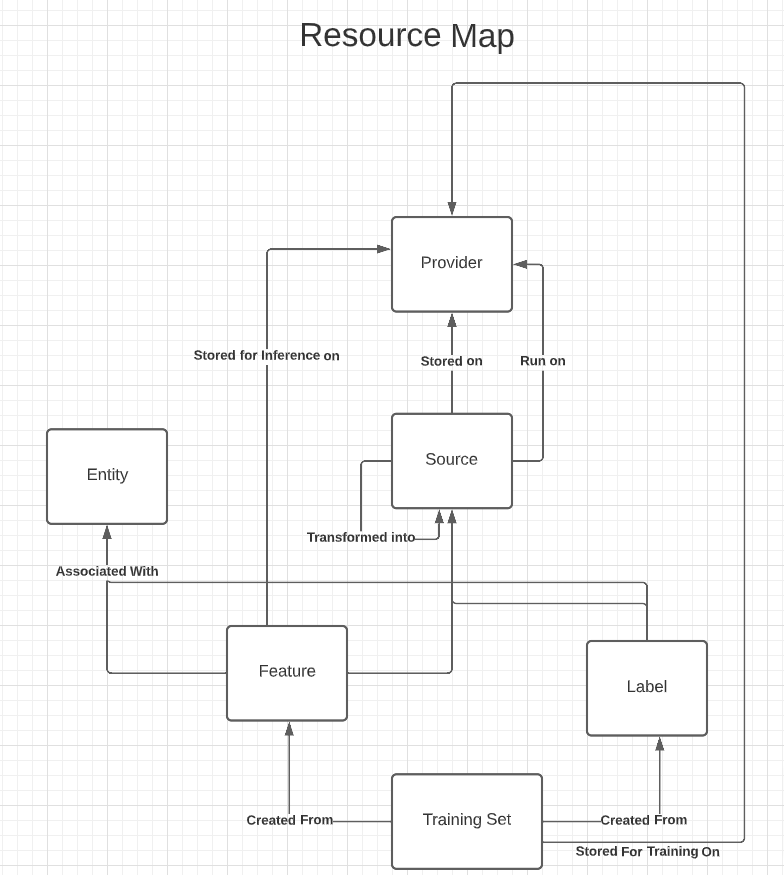

In [ ]:
client.apply()

# 🚃 [Model Training w/Served Features](https://docs.featureform.com/getting-started/serving-for-inference-and-training) 👩🏻‍🍳

> *Once the training sets and features have been created, they can be served. Featureform provides a Dataset API for training and an Inference API for feature serving.*

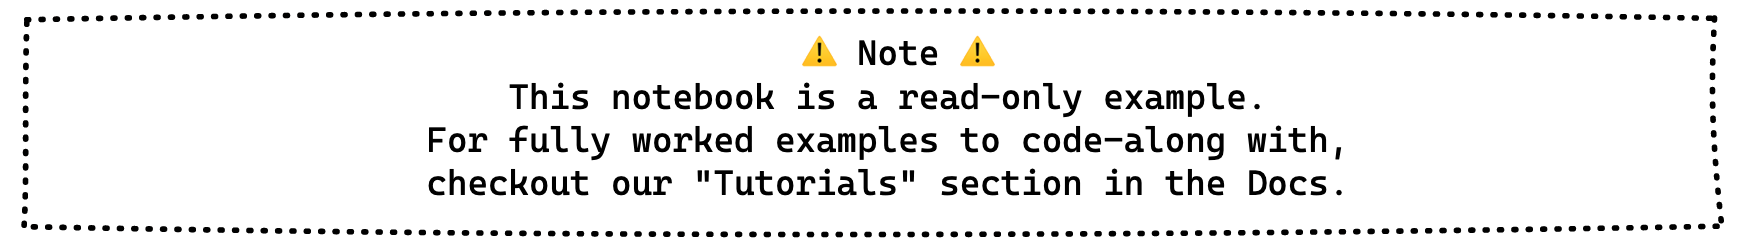

## Fetch the Training Set via Client

💬 When a [training set is defined](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#registering-training-sets), it is materialized into the [offline store](https://docs.featureform.com/getting-started/registering-infrastructure-providers#offline-store) associated with the definition. 

> *The label from the training set is zipped with the features to form a [point-in-time correct](https://docs.featureform.com/getting-started/defining-features-labels-and-training-sets#point-in-time-correctness) dataset. Once that's complete we can initialize a ServingClient and loop through the our dataset.*

In [ ]:
serving = ff.ServingClient("<INSERT-HOST>")

Here we can request a list of features associated with a specific entity & model.

In [ ]:
serving.features(["review_text"], entities={"order": "fd65651f855608ad1aa52ff4a741c31a"}, model="review_model")

['Nota3-Comprar um produto correto na capa mas interno ser outro.???????\r\n']

### Fetching the training dataset: Customer LTV

In [ ]:
customerLTV_dataset = serving.training_set("customerLTV_training", "default", model="customerLTV_training_model")

In [ ]:
for i, batch in enumerate(customerLTV_dataset):
    print("Features:", batch.features(), "Label:", batch.label())
    if i > 20:
        break

Features: [array([141.9])] Label: [141.9]
Features: [array([27.19])] Label: [27.19]
Features: [array([86.22])] Label: [86.22]
Features: [array([43.62])] Label: [43.62]
Features: [array([196.89])] Label: [196.89]
Features: [array([166.98])] Label: [166.98]
Features: [array([35.38])] Label: [35.38]
Features: [array([419.18])] Label: [419.18]
Features: [array([150.12])] Label: [150.12]
Features: [array([129.76])] Label: [129.76]
Features: [array([29.])] Label: [29.0]
Features: [array([126.26])] Label: [126.26]
Features: [array([63.66])] Label: [63.66]
Features: [array([82.05])] Label: [82.05]
Features: [array([91.28])] Label: [91.28]
Features: [array([46.85])] Label: [46.85]
Features: [array([29.])] Label: [29.0]
Features: [array([36.68])] Label: [36.68]
Features: [array([257.44])] Label: [257.44]
Features: [array([78.42])] Label: [78.42]
Features: [array([27.75])] Label: [27.75]
Features: [array([20.75])] Label: [20.75]


### Fetching the training dataset: Sentiment Analysis

In [ ]:
sentiment_dataset = serving.training_set("sentiment_prediction", "default", model="sentiment_prediction_model")

In [ ]:
for i, batch in enumerate(sentiment_dataset):
    print("Features:", batch.features(), "Label:", batch.label())
    if i > 20:
        break

Features: [array(['Top-Recomendo'], dtype='<U21')] Label: [5]
Features: [array(['super recomendo-chegou dentro do prazo e o produto é de excelente qualidade! Acabou as dores nas costas, estou dormindo muito bem!'],
      dtype='<U130')] Label: [5]
Features: [array(['super recomendo-produto de qualidade e eficiência na entrega. recebi muito antes do combinado. recomendo'],
      dtype='<U104')] Label: [5]
Features: [array(['muito boa-Gostei da atenção com a entrega'], dtype='<U41')] Label: [5]
Features: [array([' 4 - Se fosse vidro tinha quebrado; veio na caixa sem nenhuma proteção por dentro, a caixa estava muito amassada. Desculpe.. mas gosto de comprar de vcs\r\n.'],
      dtype='<U155')] Label: [4]
Features: [array(['Ótimo Produto! -Recomendo o vendedor... '], dtype='<U40')] Label: [5]
Features: [array(['Suspense-Fiz um pedido de 4 garrafas de azeite.Chegaram 2 num dia e as outras 2 quase 48 horas depois.Contato com a loja muito dificil,tanto via e-mail qto por telef.O suspense term